<a href="https://colab.research.google.com/github/ahathaway821/COVID-19-Fact-Checking/blob/master/src/exploratory-analysis/COVID_Dataset_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA on COVID-19 Poynter Dataset

In [0]:
# Load csv
import pandas as pd
import os
import re
from wordcloud import WordCloud
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import glob
import json

In [3]:
!git clone https://github.com/ahathaway821/COVID-19-Fact-Checking.git

Cloning into 'COVID-19-Fact-Checking'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 18 (delta 2), reused 4 (delta 0), pack-reused 0
Unpacking objects: 100% (18/18), done.


In [7]:
data = pd.read_csv('/content/COVID-19-Fact-Checking/data/poynterDataScraped27May2020.csv')
data.head()

,When did you see the claim?,Country 1,Country 2,Country 3,Country 4,Countries,Organization,What did you fact-check?,Who said/posted it?,URL to fact-checked article (in your language),Final rating,Explanation
0,2020/05/25,Brazil,NaN,NaN,NaN,Brazil,Agência Lupa,"Brazilian states receive a R$ 16,450 extra fu...",Facebook,https://piaui.folha.uol.com.br/lupa/2020/05/25...,FALSE,"According to the Ministry of Health, this ext..."
1,2020/05/25,India,NaN,NaN,NaN,India,FactCrescendo,COVID-19 is a bacteria causing death due to t...,Facebook/WhatsApp,https://english.factcrescendo.com/2020/05/26/f...,FALSE,COVID-19 is a virus and the theory is baseles...
2,2020/05/25,Brazil,NaN,NaN,NaN,Brazil,Agência Lupa,A video shows a group of police officers salu...,Facebook,https://piaui.folha.uol.com.br/lupa/2020/05/25...,FALSE,"The video is real, but they were not saluting..."
3,2020/05/25,India,NaN,NaN,NaN,India,FactCrescendo,Video shows a doctor claiming that If you can...,Facebook/Twitter,https://marathi.factcrescendo.com/no-holding-y...,FALSE,""" Medical Experts have clarified that being ab..."
4,2020/05/25,Spain,United States,NaN,NaN,"Spain, United States",Maldita.es,A poem signed by K. O’Meara beginning with th...,Social media,https://maldita.es/malditobulo/2020/05/25/poem...,FALSE,"It is a hoax. The title of the poem is ""In th..."


In [23]:
data.describe()

,When did you see the claim?,Country 1,Country 2,Country 3,Country 4,Countries,Organization,What did you fact-check?,Who said/posted it?,URL to fact-checked article (in your language),Final rating,Explanation
count,6577,6577,556,116,30,6577,6577,6577,6577,6576,6577,6577
unique,129,101,91,49,24,353,91,5906,1021,5977,50,5831
top,2020/03/23,India,North Africa,Kyrgyzstan,Ecuador,India,AFP,A video viewed thousands of times on Facebook...,Facebook,http://www.ecuadorchequea.com/las-mentiras-sob...,False,Please click the link to read the full article
freq,144,1270,135,10,3,1262,662,5,2020,24,3001,96


In [0]:
'''

The above shows the following

1. What did you fact-check has multiple claims which are the same. However, the rows might differ in other rows. How do we handle those scenarios?
2. We have over a 1000 unique values of "Who said/posted it?". What's the best way to filter out those? We see below that Facebook has been mentioned as FB, Facebook posts etc and these should be combined into one

'''

### Where was it posted

In [48]:
data['Who said/posted it?'].unique()

array([' Facebook', ' Facebook/WhatsApp', ' Facebook/Twitter', ...,
       ' retenews24.it',
       ' Sputnik, and then other media outlets in the Balkan regio',
       ' Emma Parker, writer at the Daily Star (and many others)'],
      dtype=object)

In [49]:
pd.value_counts(data['Who said/posted it?'])

 Facebook                                            2020
 WhatsApp                                             418
 Twitter                                              336
 Facebook, Twitter                                    222
 Many social media platforms                          215
                                                     ... 
 YouTube channel Balitang Duterte Tv                    1
 The Kenyan Voice                                       1
 WhatsApp, Twitter, Facebook, Instagram, websites       1
 Jerome Adams                                           1
 Video posted on Facebook and Youtube                   1
Name: Who said/posted it?, Length: 1021, dtype: int64

In [0]:
# We need to separate out the commas. Facebook, Twitter should add that count to Facebook as well as Twitter. FB, Facebook posts all point to Facebook as well

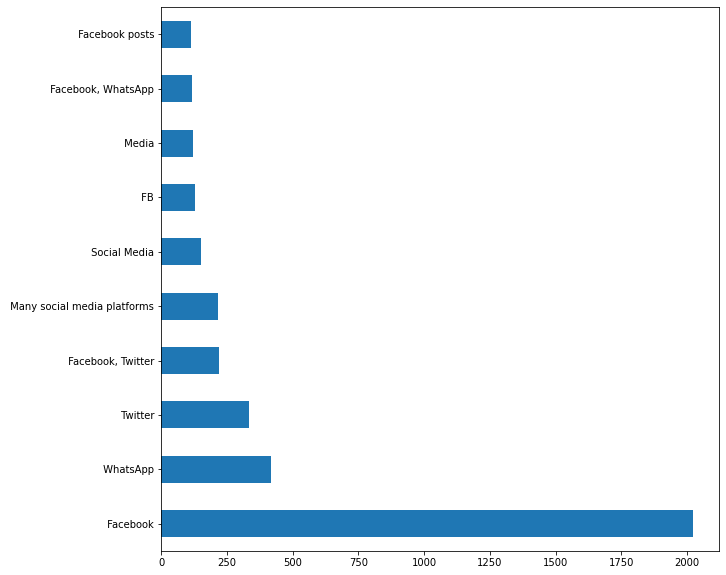

In [52]:
pd.value_counts(data['Who said/posted it?']).head(10).plot.barh(figsize=(10,10))

### Distribution of the ratings

In [28]:
data['Final rating'].unique()

array(['FALSE', 'PARTLY FALSE', 'MISLEADING', 'Partly False',
       'misleading', 'No evidence', 'False', 'Misleading', 'Partly false',
       'Mostly False', 'MOSTLY FALSE', 'mislEADING', 'partly false',
       'No Evidence', 'Mostly false', 'NO EVIDENCE', 'o evidence',
       'mostly false', 'Explanatory', 'Two Pinocchios', 'Fake',
       'half true', 'Half True', 'Mostly True', 'Suspicions',
       'PARTLY TRUE', 'True bu', 'Partly true', 'MOSTLY TRUE',
       'Partially correc', 'Misleading/False', 'Unprove',
       'Partially false', '"\\n(Org. doesn\'t apply rating)"',
       'IN DISPUTE', 'Mostly true', 'false and misleading', 'Mixed',
       'HALF TRUE', 'HALF TRUTH', 'Partially true', 'MiSLEADING',
       'Correc', 'false', 'Unlikely', 'PANTS ON FIRE',
       'Misinformation / Conspiracy theory', 'Fake news', 'Unverified',
       'Not true'], dtype=object)

In [0]:
'''
We see that MISLEADING has been spelt in various ways and is being counted separately

Fix the following
    - False, FALSE
    - Misleading, MISLEADING, misleading
    - Mostly false, Mostly False, MOSTLY FALSE
    - Partly false, PARTLY FALSE, Partly False
    - No evidence, No Evidence, o evidence
    - Explanatory
    - MOSTLY TRUE, 
    - "\n(Org. doesn't apply rating)"
    - HALF TRUE
    etc
'''

In [29]:
pd.value_counts(data['Final rating'])

False                                 3001
FALSE                                 2552
Misleading                             396
MISLEADING                             145
Mostly false                            98
Partly false                            90
misleading                              56
No evidence                             41
Explanatory                             40
Mostly False                            24
PARTLY FALSE                            17
No Evidence                             15
Partly False                            10
o evidence                               8
MOSTLY TRUE                              7
"\n(Org. doesn't apply rating)"          7
HALF TRUE                                6
MOSTLY FALSE                             6
Partially false                          5
Fake                                     4
Mostly True                              4
mostly false                             4
Two Pinocchios                           3
partly fals

In [0]:
# Convert all ratings to lowercase
data['Final rating'] = data['Final rating'].str.lower()

In [0]:
data['Final rating'] = data['Final rating'].replace({'o evidence':'no evidence'})

In [46]:
pd.value_counts(data['Final rating'])

false                                 5554
misleading                             599
mostly false                           132
partly false                           120
no evidence                             65
explanatory                             40
mostly true                             12
half true                               11
"\n(org. doesn't apply rating)"          7
partially false                          5
fake                                     4
two pinocchios                           3
partly true                              3
misleading/false                         2
suspicions                               2
not true                                 2
correc                                   2
unprove                                  2
partially correc                         1
unverified                               1
false and misleading                     1
in dispute                               1
mixed                                    1
pants on fi

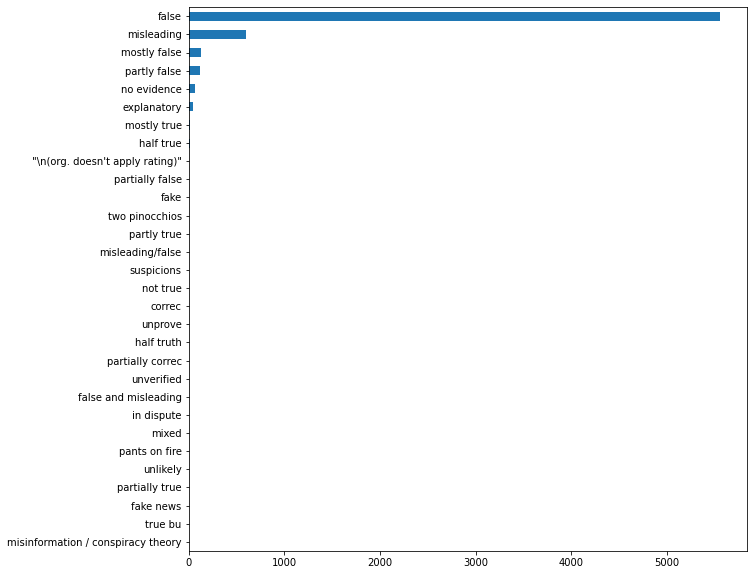

In [47]:
pd.value_counts(data['Final rating']).sort_values().plot.barh(figsize=(10,10))

### When was the claim posted

In [55]:
pd.value_counts(data['When did you see the claim?'])

2020/03/23     144
2020/03/17     141
2020/03/19     137
2020/04/02     134
2020/03/24     125
              ... 
2020/01/23       3
2020/01/21       2
2020/01/18       1
2020/01/14       1
2020/01/19       1
Name: When did you see the claim?, Length: 129, dtype: int64

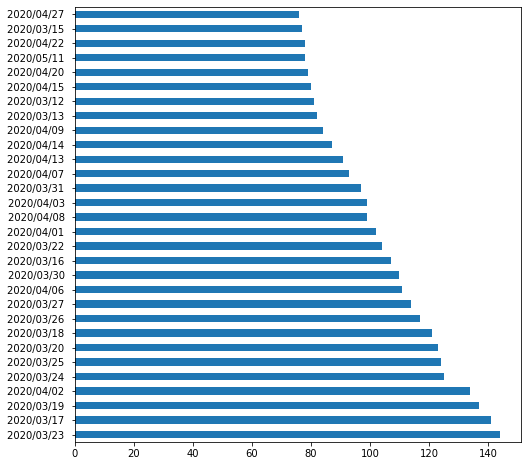

In [69]:
pd.value_counts(data['When did you see the claim?']).head(30).plot.barh(figsize=(8,8))

### Create clusters


In [0]:
# Using : https://sanjayasubedi.com.np/nlp/nlp-with-python-document-clustering/

In [13]:
# for reproducibility
random_state = 0 

df = pd.read_csv('/content/COVID-19-Fact-Checking/data/poynterDataScraped27May2020.csv',
                 usecols=["What did you fact-check?", "Final rating"])
df.columns = ['text', 'label']
df.head()

,text,label
0,"Brazilian states receive a R$ 16,450 extra fu...",FALSE
1,COVID-19 is a bacteria causing death due to t...,FALSE
2,A video shows a group of police officers salu...,FALSE
3,Video shows a doctor claiming that If you can...,FALSE
4,A poem signed by K. O’Meara beginning with th...,FALSE


In [0]:
vec = TfidfVectorizer(stop_words="english")
vec.fit(df.text.values)
features = vec.transform(df.text.values)

In [16]:
cls = MiniBatchKMeans(n_clusters=27, random_state=random_state)
cls.fit(features)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=27, n_init=3, random_state=0,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [17]:
# predict cluster labels for new dataset
cls.predict(features)

# to get cluster labels for the dataset used while
# training the model (used for models that does not
# support prediction on new dataset).
cls.labels_

array([24, 24,  4, ..., 18,  2, 18], dtype=int32)

In [0]:
# reduce the features to 2D
pca = PCA(n_components=2, random_state=random_state)
reduced_features = pca.fit_transform(features.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)

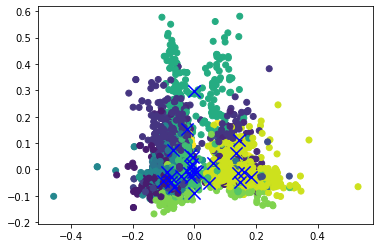

In [21]:
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(features))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')

#### Another Clustering Approach using https://www.kaggle.com/maksimeren/covid-19-literature-clustering

In [0]:
plt.style.use('ggplot')

In [0]:
df_covid = data

In [76]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6577 entries, 0 to 6576
Data columns (total 12 columns):
 #   Column                                          Non-Null Count  Dtype 
---  ------                                          --------------  ----- 
 0   When did you see the claim?                     6577 non-null   object
 1   Country 1                                       6577 non-null   object
 2   Country 2                                       556 non-null    object
 3   Country 3                                       116 non-null    object
 4   Country 4                                       30 non-null     object
 5   Countries                                       6577 non-null   object
 6   Organization                                    6577 non-null   object
 7   What did you fact-check?                        6577 non-null   object
 8   Who said/posted it?                             6577 non-null   object
 9   URL to fact-checked article (in your language)  6576

In [77]:
df_covid.head()

,When did you see the claim?,Country 1,Country 2,Country 3,Country 4,Countries,Organization,What did you fact-check?,Who said/posted it?,URL to fact-checked article (in your language),Final rating,Explanation
0,2020/05/25,Brazil,NaN,NaN,NaN,Brazil,Agência Lupa,"Brazilian states receive a R$ 16,450 extra fu...",Facebook,https://piaui.folha.uol.com.br/lupa/2020/05/25...,false,"According to the Ministry of Health, this ext..."
1,2020/05/25,India,NaN,NaN,NaN,India,FactCrescendo,COVID-19 is a bacteria causing death due to t...,Facebook/WhatsApp,https://english.factcrescendo.com/2020/05/26/f...,false,COVID-19 is a virus and the theory is baseles...
2,2020/05/25,Brazil,NaN,NaN,NaN,Brazil,Agência Lupa,A video shows a group of police officers salu...,Facebook,https://piaui.folha.uol.com.br/lupa/2020/05/25...,false,"The video is real, but they were not saluting..."
3,2020/05/25,India,NaN,NaN,NaN,India,FactCrescendo,Video shows a doctor claiming that If you can...,Facebook/Twitter,https://marathi.factcrescendo.com/no-holding-y...,false,""" Medical Experts have clarified that being ab..."
4,2020/05/25,Spain,United States,NaN,NaN,"Spain, United States",Maldita.es,A poem signed by K. O’Meara beginning with th...,Social media,https://maldita.es/malditobulo/2020/05/25/poem...,false,"It is a hoax. The title of the poem is ""In th..."


In [78]:
df_covid['claim_word_count'] = df_covid['What did you fact-check?'].apply(lambda x: len(x.strip().split()))  # word count in the claim
df_covid['explanation_word_count'] = df_covid['Explanation'].apply(lambda x: len(x.strip().split()))  # word count in explanation
df_covid['explanation_unique_words']=df_covid['Explanation'].apply(lambda x:len(set(str(x).split())))  # number of unique words in explanation
df_covid.head()

,When did you see the claim?,Country 1,Country 2,Country 3,Country 4,Countries,Organization,What did you fact-check?,Who said/posted it?,URL to fact-checked article (in your language),Final rating,Explanation,claim_word_count,explanation_word_count,explanation_unique_words
0,2020/05/25,Brazil,NaN,NaN,NaN,Brazil,Agência Lupa,"Brazilian states receive a R$ 16,450 extra fu...",Facebook,https://piaui.folha.uol.com.br/lupa/2020/05/25...,false,"According to the Ministry of Health, this ext...",16,16,16
1,2020/05/25,India,NaN,NaN,NaN,India,FactCrescendo,COVID-19 is a bacteria causing death due to t...,Facebook/WhatsApp,https://english.factcrescendo.com/2020/05/26/f...,false,COVID-19 is a virus and the theory is baseles...,9,17,15
2,2020/05/25,Brazil,NaN,NaN,NaN,Brazil,Agência Lupa,A video shows a group of police officers salu...,Facebook,https://piaui.folha.uol.com.br/lupa/2020/05/25...,false,"The video is real, but they were not saluting...",14,50,44
3,2020/05/25,India,NaN,NaN,NaN,India,FactCrescendo,Video shows a doctor claiming that If you can...,Facebook/Twitter,https://marathi.factcrescendo.com/no-holding-y...,false,""" Medical Experts have clarified that being ab...",21,21,19
4,2020/05/25,Spain,United States,NaN,NaN,"Spain, United States",Maldita.es,A poem signed by K. O’Meara beginning with th...,Social media,https://maldita.es/malditobulo/2020/05/25/poem...,false,"It is a hoax. The title of the poem is ""In th...",28,38,29


In [80]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6577 entries, 0 to 6576
Data columns (total 15 columns):
 #   Column                                          Non-Null Count  Dtype 
---  ------                                          --------------  ----- 
 0   When did you see the claim?                     6577 non-null   object
 1   Country 1                                       6577 non-null   object
 2   Country 2                                       556 non-null    object
 3   Country 3                                       116 non-null    object
 4   Country 4                                       30 non-null     object
 5   Countries                                       6577 non-null   object
 6   Organization                                    6577 non-null   object
 7   What did you fact-check?                        6577 non-null   object
 8   Who said/posted it?                             6577 non-null   object
 9   URL to fact-checked article (in your language)  6576

In [82]:
df_covid['What did you fact-check?'].describe(include='all')

count                                                  6577
unique                                                 5906
top        A video viewed thousands of times on Facebook...
freq                                                      5
Name: What did you fact-check?, dtype: object

In [83]:
# Drop duplicates?
df_covid.drop_duplicates(['What did you fact-check?', 'Explanation'], inplace=True)
df_covid['What did you fact-check?'].describe(include='all')

count                                                  5986
unique                                                 5906
top        Riots in London due to the unavailability of ...
freq                                                      3
Name: What did you fact-check?, dtype: object

In [85]:
df_covid['Explanation'].describe(include='all')

count                                                5986
unique                                               5831
top        Please click the link to read the full article
freq                                                   78
Name: Explanation, dtype: object

In [0]:
# Download the spacy bio parser

from IPython.utils import io
with io.capture_output() as captured:
    !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz

In [0]:
#NLP 
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_lg  # model downloaded in previous step

In [88]:
# Stopwords
import string

punctuations = string.punctuation
stopwords = list(STOP_WORDS)
stopwords[:10]

['or',
 'below',
 'themselves',
 'could',
 '‘ve',
 'to',
 'moreover',
 'on',
 'once',
 'beyond']

In [0]:
# Parser
parser = en_core_sci_lg.load(disable=["tagger", "ner"])
parser.max_length = 7000000

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [0]:
df = df_covid

In [97]:
from tqdm import tqdm

tqdm.pandas()
df["processed_text"] = df["What did you fact-check?"].progress_apply(spacy_tokenizer)

100%|██████████| 5986/5986 [00:24<00:00, 246.41it/s]


In [98]:
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


count    5986.000000
mean       25.405613
std        16.094163
min         0.000000
25%        14.000000
50%        22.000000
75%        33.000000
max       164.000000
Name: explanation_word_count, dtype: float64

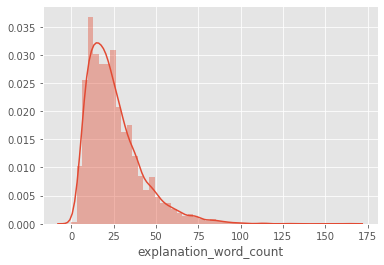

In [99]:
sns.distplot(df['explanation_word_count'])
df['explanation_word_count'].describe()

In [0]:
# Vectorization

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):
    
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

In [102]:
text = df['processed_text'].values
X = vectorize(text, 2 ** 12)
X.shape

(5986, 4096)

In [103]:
# PCA & Clustering
# reduce dimensions
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(5986, 2207)

In [105]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

# run kmeans with many different k
distortions = []
K = range(2, 50)
for k in K:
    print(k)
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    #print('Found distortion for {} clusters'.format(k))

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


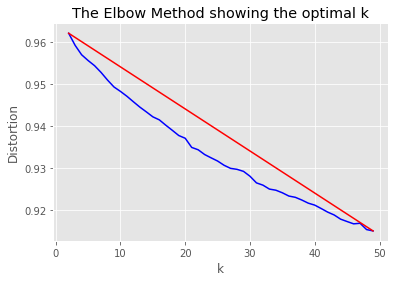

In [106]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [0]:
k = 25
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
df['y'] = y_pred

In [108]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=100, random_state=42)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 5986 samples in 4.394s...
[t-SNE] Computed neighbors for 5986 samples in 328.214s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5986
[t-SNE] Computed conditional probabilities for sample 2000 / 5986
[t-SNE] Computed conditional probabilities for sample 3000 / 5986
[t-SNE] Computed conditional probabilities for sample 4000 / 5986
[t-SNE] Computed conditional probabilities for sample 5000 / 5986
[t-SNE] Computed conditional probabilities for sample 5986 / 5986
[t-SNE] Mean sigma: 0.459621
[t-SNE] KL divergence after 250 iterations with early exaggeration: 107.750999
[t-SNE] KL divergence after 1000 iterations: 3.238742


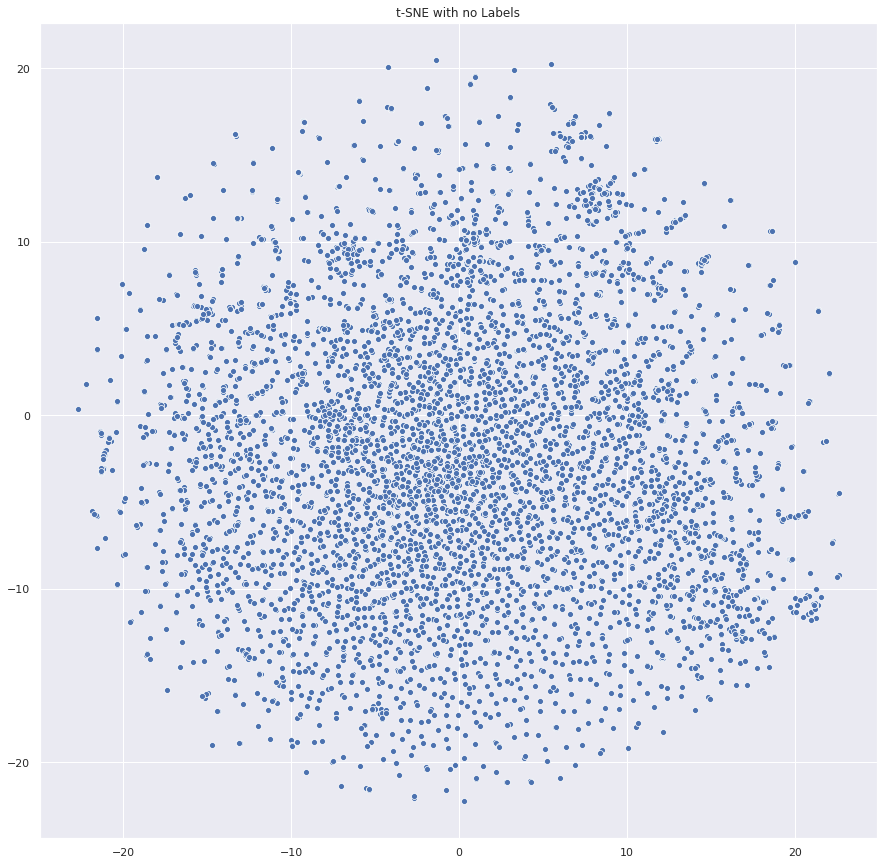

In [109]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)
plt.title('t-SNE with no Labels')
plt.savefig("t-sne_covid19.png")
plt.show()

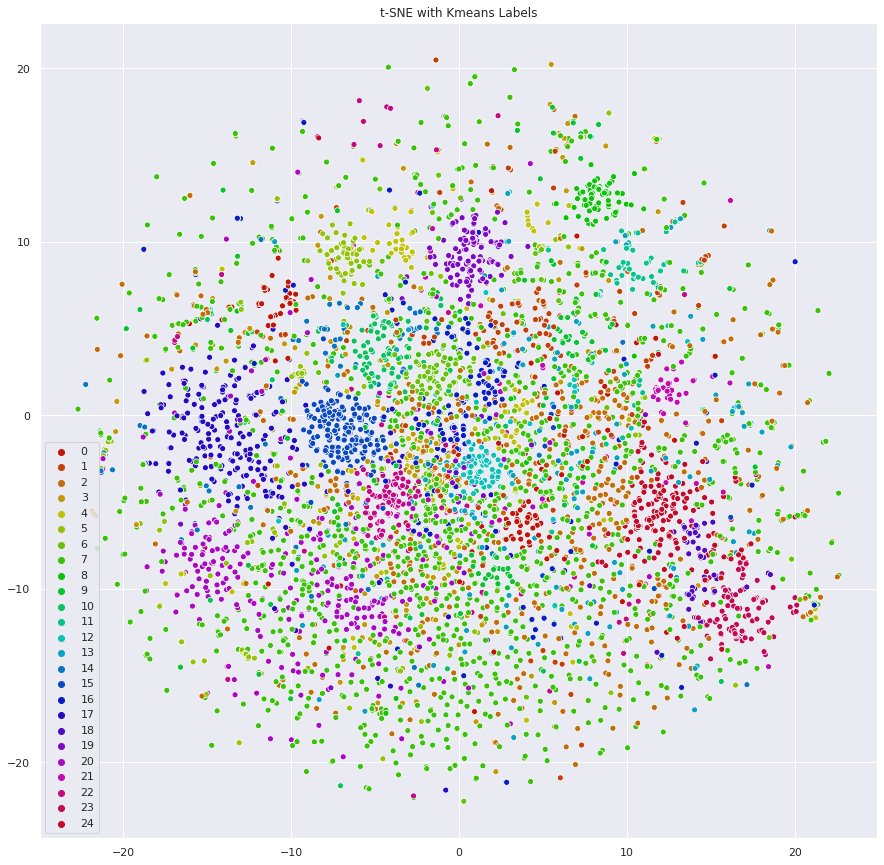

In [111]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.hls_palette(25, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("improved_cluster_tsne.png")
plt.show()

^^The location of each paper on the plot was determined by t-SNE while the label (color) was determined by k-means

In [0]:
# Topic Modeling on Each Cluster
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [0]:
vectorizers = []
    
for ii in range(0, 25):
    # Creating a vectorizer
    vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))

In [115]:
vectorizers[0]

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.9, max_features=None, min_df=5,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='[a-zA-Z\\-][a-zA-Z\\-]{2,}',
                tokenizer=None, vocabulary=None)

In [0]:
vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(df.loc[df['y'] == current_cluster, 'processed_text']))
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)

In [117]:
len(vectorized_data)

25

In [118]:
# number of topics per cluster
NUM_TOPICS_PER_CLUSTER = 25

lda_models = []
for ii in range(0, 25):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)
    
lda_models[0]

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=25, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=False)

In [0]:
clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_cluster))
    
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))

In [0]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

In [0]:
all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

In [122]:
all_keywords[0][:10]

['video',
 'coronavirus',
 'new',
 'country',
 'novel',
 'avoid',
 'people',
 'stop',
 'world',
 'road']

In [123]:
len(all_keywords)

25

In [0]:
f=open('topics.txt','w')

count = 0

for ii in all_keywords:

    if vectorized_data[count] != None:
        f.write(', '.join(ii) + "\n")
    else:
        f.write("Not enough instances to be determined. \n")
        f.write(', '.join(ii) + "\n")
    count += 1

f.close()

In [0]:
import pickle

# save the COVID-19 DataFrame, too large for github
pickle.dump(df, open("df_covid.p", "wb" ))

# save the final t-SNE
pickle.dump(X_embedded, open("X_embedded.p", "wb" ))

# save the labels generate with k-means(20)
pickle.dump(y_pred, open("y_pred.p", "wb" ))

In [0]:
# function to print out classification model report
def classification_report(model_name, test, pred):
    from sklearn.metrics import precision_score, recall_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import f1_score
    
    print(model_name, ":\n")
    print("Accuracy Score: ", '{:,.3f}'.format(float(accuracy_score(test, pred)) * 100), "%")
    print("     Precision: ", '{:,.3f}'.format(float(precision_score(test, pred, average='macro')) * 100), "%")
    print("        Recall: ", '{:,.3f}'.format(float(recall_score(test, pred, average='macro')) * 100), "%")
    print("      F1 score: ", '{:,.3f}'.format(float(f1_score(test, pred, average='macro')) * 100), "%")

In [127]:
from sklearn.model_selection import train_test_split

# test set size of 20% of the data and the random seed 42 <3
X_train, X_test, y_train, y_test = train_test_split(X.toarray(),y_pred, test_size=0.2, random_state=42)

print("X_train size:", len(X_train))
print("X_test size:", len(X_test), "\n")

X_train size: 4788
X_test size: 1198 



In [128]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier

# SGD instance
sgd_clf = SGDClassifier(max_iter=10000, tol=1e-3, random_state=42, n_jobs=4)
# train SGD
sgd_clf.fit(X_train, y_train)

# cross validation predictions
sgd_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3, n_jobs=4)

# print out the classification report
classification_report("Stochastic Gradient Descent Report (Training Set)", y_train, sgd_pred)

Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  92.439 %
     Precision:  93.766 %
        Recall:  90.203 %
      F1 score:  91.752 %


In [129]:
# cross validation predictions
sgd_pred = cross_val_predict(sgd_clf, X_test, y_test, cv=3, n_jobs=4)

# print out the classification report
classification_report("Stochastic Gradient Descent Report (Training Set)", y_test, sgd_pred)

Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  85.559 %
     Precision:  88.793 %
        Recall:  79.946 %
      F1 score:  83.381 %


In [130]:
sgd_cv_score = cross_val_score(sgd_clf, X.toarray(), y_pred, cv=10)
print("Mean cv Score - SGD: {:,.3f}".format(float(sgd_cv_score.mean()) * 100), "%")

Mean cv Score - SGD: 93.034 %


In [0]:
# Plotting the data

In [133]:
!git clone https://github.com/MaksimEkin/COVID19-Literature-Clustering.git

Cloning into 'COVID19-Literature-Clustering'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 651 (delta 23), reused 4 (delta 1), pack-reused 605
Receiving objects: 100% (651/651), 223.06 MiB | 12.67 MiB/s, done.
Resolving deltas: 100% (322/322), done.
Checking out files: 100% (42/42), done.


In [135]:
!pwd
!cd COVID19-Literature-Clustering/lib

/content


In [138]:
cd COVID19-Literature-Clustering/lib

/content/COVID19-Literature-Clustering/lib


In [0]:
# required libraries for plot
from call_backs import input_callback, selected_code  # file with customJS callbacks for bokeh
                                                      # github.com/MaksimEkin/COVID19-Literature-Clustering/blob/master/lib/call_backs.py

In [140]:
!pip install bokeh

In [0]:
import bokeh
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, CustomJS, Slider, TapTool, TextInput
from bokeh.palettes import Category20
from bokeh.transform import linear_cmap, transform
from bokeh.io import output_file, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import RadioButtonGroup, TextInput, Div, Paragraph
from bokeh.layouts import column, widgetbox, row, layout
from bokeh.layouts import column

In [142]:
cd /content/

/content


In [0]:
import os

topic_path = 'topics.txt'
with open(topic_path) as f:
    topics = f.readlines()

In [145]:
df.head()

,When did you see the claim?,Country 1,Country 2,Country 3,Country 4,Countries,Organization,What did you fact-check?,Who said/posted it?,URL to fact-checked article (in your language),Final rating,Explanation,claim_word_count,explanation_word_count,explanation_unique_words,processed_text,y
0,2020/05/25,Brazil,NaN,NaN,NaN,Brazil,Agência Lupa,"Brazilian states receive a R$ 16,450 extra fu...",Facebook,https://piaui.folha.uol.com.br/lupa/2020/05/25...,false,"According to the Ministry of Health, this ext...",16,16,16,"brazilian state receive r$ 16,450 extra fund f...",12
1,2020/05/25,India,NaN,NaN,NaN,India,FactCrescendo,COVID-19 is a bacteria causing death due to t...,Facebook/WhatsApp,https://english.factcrescendo.com/2020/05/26/f...,false,COVID-19 is a virus and the theory is baseles...,9,17,15,covid-19 bacterium cause death thrombosis,12
2,2020/05/25,Brazil,NaN,NaN,NaN,Brazil,Agência Lupa,A video shows a group of police officers salu...,Facebook,https://piaui.folha.uol.com.br/lupa/2020/05/25...,false,"The video is real, but they were not saluting...",14,50,44,video group police officer salute anti-lockdow...,17
3,2020/05/25,India,NaN,NaN,NaN,India,FactCrescendo,Video shows a doctor claiming that If you can...,Facebook/Twitter,https://marathi.factcrescendo.com/no-holding-y...,false,""" Medical Experts have clarified that being ab...",21,21,19,video doctor claim hold breath 10 sec discomfo...,7
4,2020/05/25,Spain,United States,NaN,NaN,"Spain, United States",Maldita.es,A poem signed by K. O’Meara beginning with th...,Social media,https://maldita.es/malditobulo/2020/05/25/poem...,false,"It is a hoax. The title of the poem is ""In th...",28,38,29,poem sign k. o’meara begin verse “ people stay...,7


In [146]:
# show on notebook
output_notebook()
# target labels
y_labels = y_pred

# data sources
source = ColumnDataSource(data=dict(
    x= X_embedded[:,0], 
    y= X_embedded[:,1],
    x_backup = X_embedded[:,0],
    y_backup = X_embedded[:,1],
    desc= y_labels, 
    titles= df['What did you fact-check?'],
    labels = ["C-" + str(x) for x in y_labels]
    ))

# hover over information
hover = HoverTool(tooltips=[
    ("Title", "@titles{safe}")
],
point_policy="follow_mouse")

# map colors
mapper = linear_cmap(field_name='desc', 
                     palette=Category20[20],
                     low=min(y_labels) ,high=max(y_labels))

# prepare the figure
plot = figure(plot_width=1200, plot_height=850, 
           tools=[hover, 'pan', 'wheel_zoom', 'box_zoom', 'reset', 'save', 'tap'], 
           title="Clustering of the COVID-19 Literature with t-SNE and K-Means", 
           toolbar_location="above")

# plot settings
plot.scatter('x', 'y', size=5, 
          source=source,
          fill_color=mapper,
          line_alpha=0.3,
          line_color="black",
          legend = 'labels')
plot.legend.background_fill_alpha = 0.6

In [0]:
# Keywords
text_banner = Paragraph(text= 'Keywords: Slide to specific cluster to see the keywords.', height=45)
input_callback_1 = input_callback(plot, source, text_banner, topics)

# currently selected article
div_curr = Div(text="""Click on a plot to see the link to the article.""",height=150)
callback_selected = CustomJS(args=dict(source=source, current_selection=div_curr), code=selected_code())
taptool = plot.select(type=TapTool)
taptool.callback = callback_selected

# WIDGETS
slider = Slider(start=0, end=20, value=20, step=1, title="Cluster #", callback=input_callback_1)
keyword = TextInput(title="Search:", callback=input_callback_1)

# pass call back arguments
input_callback_1.args["text"] = keyword
input_callback_1.args["slider"] = slider

In [0]:
# STYLE
slider.sizing_mode = "stretch_width"
slider.margin=15

keyword.sizing_mode = "scale_both"
keyword.margin=15

div_curr.style={'color': '#BF0A30', 'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
div_curr.sizing_mode = "scale_both"
div_curr.margin = 20

text_banner.style={'color': '#0269A4', 'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
text_banner.sizing_mode = "scale_both"
text_banner.margin = 20

plot.sizing_mode = "scale_both"
plot.margin = 5

r = row(div_curr,text_banner)
r.sizing_mode = "stretch_width"

In [150]:
# LAYOUT OF THE PAGE
l = layout([
    [slider, keyword],
    [text_banner],
    [div_curr],
    [plot],
])
l.sizing_mode = "scale_both"

# show
output_file('t-sne_covid-19_interactive.html')
show(l)